In [1]:
using Pkg
Pkg.activate("..")

"/Users/ppalmes/julia/TSML.jl/Project.toml"

In [2]:
ENV["LOAD_SK_CARET"]="false"
using TSML
using TSML.TSMLTransformers
using DataFrames
using Dates
using CSV
using Plots
using GR
using Random

┌ Info: Recompiling stale cache file /Users/ppalmes/.julia/compiled/v1.0/TSML/6btmi.ji for TSML [486c3eca-181c-11e9-1ec4-1d6993a4262d]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/ppalmes/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


In [3]:
fname ="testdata.csv"
dat = CSV.read(fname)
rename!(dat,names(dat)[1]=>:Date,names(dat)[2]=>:Value)
dat[:Date] = DateTime.(dat[:Date],"d/m/y H:M")
orig = deepcopy(dat)
filter1 = DateValgator()
filter2 = DateValNNer(Dict(:nnsize=>1))

DateValNNer(nothing, Dict{Symbol,Any}(:strict=>true,:dateinterval=>1 hour,:nnsize=>1,:missdirection=>:symmetric))

In [4]:
fit!(filter1,dat,[])
res1=transform!(filter1,dat)
(first(res1,5),size(res1,1))

(5×2 DataFrame
│ Row │ Date                │ Value   │
│     │ DateTime            │ Float64 │
├─────┼─────────────────────┼─────────┤
│ 1   │ 2014-01-01T00:00:00 │ 10.0    │
│ 2   │ 2014-01-01T01:00:00 │ 9.9     │
│ 3   │ 2014-01-01T02:00:00 │ 10.0    │
│ 4   │ 2014-01-01T03:00:00 │ 10.0    │
│ 5   │ 2014-01-01T04:00:00 │ 10.0    │, 3830)

In [5]:
fit!(filter2,res1,[])
res2=transform!(filter2,res1)
(first(res2,5),size(res2,1))

(5×2 DataFrame
│ Row │ Date                │ Value    │
│     │ DateTime            │ Float64⍰ │
├─────┼─────────────────────┼──────────┤
│ 1   │ 2014-01-01T00:00:00 │ 10.0     │
│ 2   │ 2014-01-01T01:00:00 │ 9.9      │
│ 3   │ 2014-01-01T02:00:00 │ 10.0     │
│ 4   │ 2014-01-01T03:00:00 │ 10.0     │
│ 5   │ 2014-01-01T04:00:00 │ 10.0     │, 8761)

In [6]:
mypipeline = Pipeline(Dict(
        :transformers => [filter1,filter2]
    )
)

Pipeline(nothing, Dict{Symbol,Union{Nothing, Array{Transformer,1}}}(:transformers=>Transformer[DateValgator(Dict{Symbol,Any}(:dateinterval=>1 hour), Dict{Symbol,Any}(:dateinterval=>1 hour)), DateValNNer(Dict{Symbol,Any}(:loopcount=>1,:strict=>true,:dateinterval=>1 hour,:missingcount=>4931,:nnsize=>1,:missdirection=>:symmetric), Dict{Symbol,Any}(:loopcount=>1,:strict=>true,:dateinterval=>1 hour,:missingcount=>4931,:nnsize=>1,:missdirection=>:symmetric))],:transformer_args=>nothing))

In [7]:
fit!(mypipeline,dat,[])
resp = transform!(mypipeline,dat)
first(resp,5)

,Date,Value
,DateTime,Float64⍰
1,2014-01-01T00:00:00,10.0
2,2014-01-01T01:00:00,9.9
3,2014-01-01T02:00:00,10.0
4,2014-01-01T03:00:00,10.0
5,2014-01-01T04:00:00,10.0


In [8]:
using TSML.TSMLTypes
import TSML.TSMLTypes.fit!
import TSML.TSMLTypes.transform!

mutable struct CSVDateValReader <: Transformer
    model
    args
    function CSVDateValReader(args=Dict())
        default_args = Dict(
            :filename => "",
            :dateformat => ""
        )
        new(nothing,mergedict(default_args,args))
    end
end
function fit!(csvrdr::CSVDateValReader,x::T=[],y::Vector=[]) where {T<:Union{DataFrame,Vector,Matrix}}
    fname = csvrdr.args[:filename]
    fmt = csvrdr.args[:dateformat]
    (fname != "" && fmt != "") || error("missing filename or date format")
    model = csvrdr.args
end

function transform!(csvrdr::CSVDateValReader,x::T=[]) where {T<:Union{DataFrame,Vector,Matrix}}
    fname = csvrdr.args[:filename]
    fmt = csvrdr.args[:dateformat]
    df = CSV.read(fname)
    ncol(df) == 2 || error("dataframe should have only two columns: Date,Value")
    rename!(df,names(df)[1]=>:Date,names(df)[2]=>:Value)
    df[:Date] = DateTime.(df[:Date],fmt)
    df
end

transform! (generic function with 21 methods)

In [9]:
csvreader = CSVDateValReader(Dict(:filename=>"testdata.csv",:dateformat=>"d/m/y H:M"))
fit!(csvreader)
res=transform!(csvreader)
first(res,5)

,Date,Value
,DateTime,Float64⍰
1,2014-01-01T00:06:00,10.0
2,2014-01-01T00:18:00,10.0
3,2014-01-01T00:29:00,10.0
4,2014-01-01T00:40:00,9.9
5,2014-01-01T00:51:00,9.9


In [10]:
mypipeline = Pipeline(Dict(
        :transformers => [csvreader,filter1,filter2]
    )
)
fit!(mypipeline)
res=transform!(mypipeline)
first(res,5)

,Date,Value
,DateTime,Float64⍰
1,2014-01-01T00:00:00,10.0
2,2014-01-01T01:00:00,9.9
3,2014-01-01T02:00:00,10.0
4,2014-01-01T03:00:00,10.0
5,2014-01-01T04:00:00,10.0


In [11]:
filter2.args[:missingcount]

4931

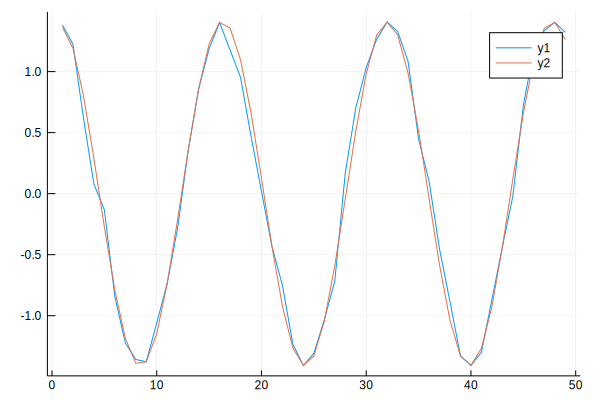

In [12]:
mydate=DateTime(2014,1,1):Dates.Minute(15):DateTime(2014,1,3) # 15 minutes interval
values = Array{Union{Float64,Missing}}(sin.(1:0.1:length(mydate)) .+ cos.(1:0.1:length(mydate)))[1:length(mydate)];
x = DataFrame(Date=mydate,Value=values); xx = deepcopy(x);first(x,10)
nmissing=floor(nrow(x) * 0.50) |> Integer
ndxmissing=Random.shuffle(1:nrow(x))[1:nmissing]
x[:Value][ndxmissing] .= missing; first(x,15)
dvtr = TSML.DateValgator()
TSML.fit!(dvtr,x,[]);TSML.fit!(dvtr,xx,[])
inputx = TSML.transform!(dvtr,x); inputxx = TSML.transform!(dvtr,xx);
dvnnr = TSML.DateValNNer(Dict(:dateinterval=>Dates.Hour(1),:nnsize=>1))
TSML.fit!(dvnnr,inputx,[])
pred_y=TSML.transform!(dvnnr,inputx);pred_yy=TSML.transform!(dvnnr,inputxx);
Plots.plot([pred_y[:Value],pred_yy[:Value]])

In [13]:
sqrt(sum(pred_y[:Value]-pred_yy[:Value]).^2)

0.1696288776926687

In [14]:
rename!(pred_y,:Value=>:MissingVals);

In [15]:
jx = join(pred_y,pred_yy,on=:Date)
jx[:error] = (jx[:MissingVals] .- jx[:Value]).^2;jx

,Date,MissingVals,Value,error
,DateTime,Float64⍰,Float64⍰,Float64
1,2014-01-01T00:00:00,1.38177,1.36329,0.000341692
2,2014-01-01T01:00:00,1.22491,1.19324,0.00100298
3,2014-01-01T02:00:00,0.623011,0.804733,0.033023
4,2014-01-01T03:00:00,0.0794292,0.289179,0.0439951
5,2014-01-01T04:00:00,-0.132301,-0.272029,0.019524
6,2014-01-01T05:00:00,-0.844632,-0.790291,0.00295294
7,2014-01-01T06:00:00,-1.22234,-1.18378,0.00148664
8,2014-01-01T07:00:00,-1.35861,-1.39038,0.00100955
9,2014-01-01T08:00:00,-1.37747,-1.37747,0.0
